# Analyzing the point process of doctor visits

In this assignment for the lecture *Social Data Science*, we were looking at synthetic data about patients of some imaginary doctor´s office:
- **patients.csv** contains information like weight and gender about all the patients.
- **visits.csv** stores information about each visit of a patient (particularly the time). 

In **Part 1** we are looking at the time intervals between the first and the second visit of a patient and estimate a simple survival model of the event of the second visit (with and without covariates). In **Part 2** we consider a process with events that can happen multiple times (all visits) and in **Part 3** we are also considering covariates that vary with time.

In [2]:
#We need the following libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from lifelines import ExponentialFitter
from lifelines import CoxPHFitter
from lifelines import CoxTimeVaryingFitter

# Part 1

First we load the entire data set and vizualize some of it to get a better understanding. Therefor we create a scatterplot of the point process data for the first 10 patients (id $\leq$ 10).


Text(0.5, 1.0, 'Doctor visits of first 10 patients over time')

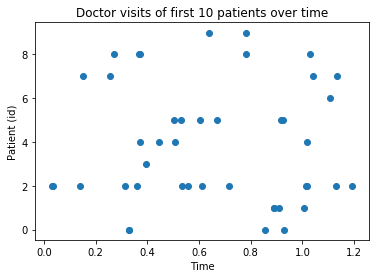

In [3]:
# load entire data into dataframes
df_patients = pd.read_csv("data/patients.csv")
df_time_large = pd.read_csv("data/visits.csv")

# derive small dataset used for demo
df_time_small = df_time_large[df_time_large.patient <10]

# plot small dataset
plt.scatter(df_time_small.time, df_time_small.patient)
plt.xlabel("Time")
plt.ylabel("Patient (id)")
plt.title("Doctor visits of first 10 patients over time")


We are interested in investigating the time between the first and the second doctors visit. 
We assume that we investigate the data up until certain timepoints [0.1, 0.2, ... 1.2]. This means that in the first observation period only data with times less or equal to 0.1 ($\leq$) is available. For second period data less than 0.2 is available and so on, increasing by 0.1 for each step up until 1.2.

The function `prepare_analysis` extracts the time of the first and second visit only considering data with time up to and including the threshold `t`.
Patients which did not have their first visit within the considered interval are not included. Otherwise, if the second visit is not in the interval, it is indicated with a NaN value.


In [8]:
def prepare_analysis(df_time : pd.DataFrame, t : float) -> pd.DataFrame:
    df = df_time[df_time.time <= t].copy()
    out = {"patient": [], "first" : [], "second" :  []}
    for index, visit in df.iterrows():
        if visit.patient in out["patient"]:
            idx = out["patient"].index(visit.patient)
            if np.isnan(out["second"][idx]):
                out["second"][idx] = visit.time
        else:
            out["patient"].append(int(visit.patient))
            out["first"].append(visit.time)
            out["second"].append(np.nan)
    return pd.DataFrame(out).set_index("patient").sort_index()

In [12]:
#example output of prepare_analysis
prepare_analysis(df_time_small, t = 0.4)

,first,second
patient,,
0,0.329409,0.330142
2,0.031050,0.034792
3,0.392886,NaN
4,0.371249,NaN
7,0.149173,0.255098
8,0.269761,0.369204


We will now consider two approaches to filter the data. 
- The function `filter_1` returns the time between the first and second visit discarding those that did not have their first *and* second visit within the considered time interval.
- The function `filter_2` keeps information on patients whose first visit is in the considered interval but whose second visit is not. It returns the time between first and second visit or the end of the observed time interval as well as a second argument which indicates whether the second visit was acutally observed.

In [13]:
def filter_1(df : pd.DataFrame) -> pd.Series:
    return df.dropna()["second"]-df.dropna()["first"]

def filter_2(df : pd.DataFrame, t : float) -> (pd.Series, pd.Series):
    df_out = df.copy()
    df_out["duration"] = df["second"].subtract(df["first"], fill_value = t)
    df_out["observed"] = np.invert(np.isnan(df["second"]))
    df_out.drop(["first", "second"], axis = 1, inplace = True)
    return df_out

In [14]:
#example output of filter_1
filter_1(prepare_analysis(df_time_small, t = 0.4))

patient
0    0.000733
2    0.003741
7    0.105925
8    0.099443
dtype: float64

In [16]:
#example output of filter_2
filter_2(prepare_analysis(df_time_small, t = 0.4), t = 0.4)

,duration,observed
patient,,
0,0.000733,True
2,0.003741,True
3,0.007114,False
4,0.028751,False
7,0.105925,True
8,0.099443,True


For each of the thresholds `t in [0.1, 0.2, ... 1.2]` we will now estimate the hazard rate of the second visit using the `ExponentialFitter` from the `lifelines` library. We plot the estimated values of the hazard rate as a function of different thresholds `t` for both `filter_1` and `filter_2` to compare both approaches.

For the case considered here the `.fit` function of the the `ExponentialFitter` requires only 1 or 2 arguments. The first argument is the length of intervals until the observed event (or in this case, the timespan between two events).
The second optional argument is only needed when accounting for potential censoring. We pass a boolean array with information on censoring as a second argument to the `.fit` function. 1s are indicating an observed end, and 0s indicating still waiting for the end. The end here is "second visit".

In [19]:
#define thresholds [0.1, 0.2, ... 1.2]
thresholds = np.arange(0.1, 1.3, 0.1)

#compute hazard rates for different thresholds using filter_1
hazards_1 = []
for t in thresholds:
    data_1 = filter_1(prepare_analysis(df_time_large, t))
    exfitter = ExponentialFitter().fit(data_1)    
    hazards_1.append(1 / exfitter.lambda_)

#compute hazard rates for different thresholds using the filter_2
hazards_2 = []
for t in thresholds:
    data_2 = filter_2(prepare_analysis(df_time_large, t), t)
    exfitter = ExponentialFitter().fit(data_2["duration"], data_2["observed"])
    hazards_2.append(1 / exfitter.lambda_)

Text(0.5, 1.0, 'estimated hazard rates')

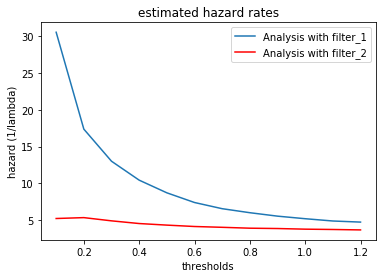

In [24]:
#plot the estimated hazard rates
plt.errorbar(thresholds, hazards_1, label = "Analysis with filter_1")
plt.errorbar(thresholds, hazards_2, color = "red", label = "Analysis with filter_2")
plt.xlabel("thresholds")
plt.ylabel("hazard (1/lambda)")
plt.legend()
plt.title("estimated hazard rates")

### Observation 1
There are two observations you can derive from the plot above: 
1. The estimated hazard rate decreases for larger time intervals. This is especially the case for the analysis with filter_1.
In the case of filter_1 the reason could be that by only looking at patients that had two visits before the threshold, we are only
looking at small intervals and therefore overestimate the hazard. 
For filter_2 it could that patients that visit the doctor early in our observation period are likely to go to the doctor more often
and therefore return more quickly.
2. The estimated hazard rate for filter_1 is (much) higher than for filter_2. This is because in filter_1 we only look at instances that
already had their second visit, so we leave out longer time periods.


We now want to investigate the impact of covariates on the time between first and second visit.

To that extend we create a DataFrame `df_cov_part1` with columns `['duration', 'observed', 'age', 'height', 'woman', 'weight']` by joining the patient data (`patients.csv`) with the data on duration between first and second visit obtained via `prepare_analysis` and `filter_2`.

We then fit a CoxPH model using the `CoxPHFitter` from the lifelines library to the entire dataset.

In [45]:
df_cov_part1 = filter_2(prepare_analysis(df_time_large, 1.2), 1.2).join(df_patients)

In [46]:
cph_part1 = CoxPHFitter().fit(df_cov_part1, "duration", "observed")

In [52]:
#print summary of fitted model
cph_part1.print_summary(style = "ascii", decimals = 5)

<lifelines.CoxPHFitter: fitted with 954 total observations, 94 right-censored observations>
             duration col = 'duration'
                event col = 'observed'
      baseline estimation = breslow
   number of observations = 954
number of events observed = 860
   partial log-likelihood = -5098.54194
         time fit was run = 2022-12-04 12:17:04 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
age        0.00541    1.00542    0.00368         -0.00181          0.01263              0.99819              1.01271
height     0.07718    1.08024    0.29852         -0.50791          0.66228              0.60175              1.93921
woman     -0.08367    0.91974    0.07130         -0.22341          0.05607              0.79979              1.05767
weight     0.01977    1.01997    0.00317        

### Observation 2
The coefficents of the CoxPH model indicate that an older age or a higher weight leads to returning to the doctor more quickly, while women tend to wait longer between their visits.

## Part 2

So far we were only concerned with the time between the first and second doctors visit. We will now be using the entire dataset to predict the time between doctors visits. This is a little bit of an unsual scenario for survival analysis as each individual can experience the event more than once, but the methods used to analyse this problem are very similar to the once already explored.

The function `prepare_analysis_all` computes the duration between all doctors visits for each patient. Note, that for all of the patients their final visit is not recorded. This is indicated by the returned *observed* column.

In [38]:
def prepare_analysis_all(df_time : pd.DataFrame, t : float) -> pd.DataFrame:
    df = df_time[df_time.time <= t].copy()
    out = {"patient": [], "observed" : [], "duration" :  []}
    for patient in np.sort(df["patient"].unique()):
        df_patient = df[df["patient"] == patient]
        length = len(df_patient)
        out["patient"] += [patient] * length
        out["observed"] += ([True] * (length-1) + [False])
        out["duration"] += list(-df_patient["time"]+df_patient["time"].shift(-1, fill_value = t))
    return pd.DataFrame(out)

In [44]:
#example output of prepare_analysis_all
prepare_analysis_all(df_time_small, t = 0.4).head(10)

,patient,observed,duration
0,0,True,0.000733
1,0,False,0.069858
2,2,True,0.003741
3,2,True,0.104157
4,2,True,0.175687
5,2,True,0.045316
6,2,False,0.040048
7,3,False,0.007114
8,4,False,0.028751
9,7,True,0.105925


Like in **Part 1** we no use the covariates in `patients.csv` in a CoxPH model but now modeling the entire dataset (using `prepare_analysis_all`) rather than the visits between the first and second visit only.
First we join the data sets (`df_cov_part2`), then we fit the model (`cph_part2`) accounting for the fact that the observations are not independent (rememember you have multiple observations for one patient) by using the `cluster_col` argument..

In [49]:
df_cov_part2 = prepare_analysis_all(df_time_large, 1.2).join(df_patients, on = "patient")

In [50]:
cph_part2 = CoxPHFitter().fit(df_cov_part2, "duration", "observed", cluster_col = "patient")

In [54]:
#print summary of fitted model
cph_part2.print_summary(style = "ascii", decimals = 5)

<lifelines.CoxPHFitter: fitted with 4890 total observations, 954 right-censored observations>
             duration col = 'duration'
                event col = 'observed'
              cluster col = 'patient'
          robust variance = True
      baseline estimation = breslow
   number of observations = 4890
number of events observed = 3936
   partial log-likelihood = -29571.03405
         time fit was run = 2022-12-04 12:20:23 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
age        0.00255    1.00255    0.00182         -0.00102          0.00611              0.99898              1.00613
height    -0.30139    0.73979    0.15801         -0.61109          0.00830              0.54276              1.00834
woman     -0.11168    0.89433    0.03463         -0.17956         -0.04380              0

## Part 3

When looking at the data, you might notice that the visits have an attached "type" property which indicates the kind of treatment that happened (0=diagnoses only, 1=treatment only, 2=diagnoses & treatment). You might think that if a patient has been diagnosed but did not yet receive a treatment, he is more likely to return soon. To prove this hypothesis we will analyze wether `type=0` strongly increases the hazard for that patient.

So far we have only looked at the case where the covariates are constant over the observation period. In order to account for the type of visit, this needs to change. 

In `lifelines` time varying covariates are encoded using the "long" format (see [documentation](https://lifelines.readthedocs.io/en/latest/Time%20varying%20survival%20regression.html)). In the long format information is encoded in a start and stop time. During this timespan it is assumed, that the covariates are constant.

We thus need to encode our point process data in the long format (i.e. denote the start and stop) and we also associate each timespan with the type of the starting event. This is done in the function `prepare_analysis_long`.
We then join this long format data with the patient information and fit a time varying CoxPH model (`cph_part3`) to the data.


In [57]:
def prepare_analysis_long(df_time : pd.DataFrame, max_t : float) -> pd.DataFrame:
    df = df_time[df_time.time <= max_t].copy()
    out = {"patient": [], "start" :  [], "stop": [], "observed" : [], "type" : []}
    for patient in np.sort(df["patient"].unique()):
        df_patient = df[df["patient"] == patient]
        length = len(df_patient)
        out["patient"] += [patient] * length
        out["observed"] += ([True] * (length-1) + [False])
        out["start"] += list(df_patient["time"])
        out["stop"] += list(df_patient["time"].shift(-1, fill_value = max_t))
        out["type"] += list(df_patient["type"].copy())
    return pd.DataFrame(out)

In [62]:
#prepare the data via prepare_analysis_long, join it with patient info and only look at type == 0
df_cov_part3 = pd.get_dummies(prepare_analysis_long(df_time_large, 1.2).join(df_patients, on = "patient"), columns = ["type"])
df_cov_part3.drop(["type_1.0", "type_2.0"], axis = 1, inplace = True)

In [63]:
cph_part3 = CoxTimeVaryingFitter().fit(df_cov_part3, "observed", id_col="patient")

In [64]:
cph_part3.print_summary(style = "ascii", decimals = 5)

<lifelines.CoxTimeVaryingFitter: fitted with 4890 periods, 954 subjects, 3936 events>
         event col = 'observed'
number of subjects = 954
 number of periods = 4890
  number of events = 3936
partial log-likelihood = -25484.97694
  time fit was run = 2022-12-04 12:37:23 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
age        0.00269    1.00269    0.00171         -0.00067          0.00605              0.99933              1.00607
height    -0.35413    0.70178    0.14731         -0.64285         -0.06542              0.52579              0.93667
woman     -0.14241    0.86726    0.03420         -0.20945         -0.07538              0.81103              0.92739
weight     0.02432    1.02461    0.00141          0.02155          0.02708              1.02178              1.02745
type_0.0   1.06

### Observation 4
The summary of our model indeed indicates that visits with type 0 (only diagnosis) lead to a smaller time period until the patient returns.